In [2]:
%matplotlib inline
from pypxr.structure import *
from pypxr.reflectivity import *
import matplotlib.pyplot as plt
import seaborn as sns
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, BaseObjective
import pandas as pd
sns.set_style("darkgrid")
from warnings import filterwarnings
filterwarnings('ignore')

# Fitting the Room Temperature Data

The main process here is to refine the reflectivity measured using multiple photon energies simultaneously. The current procedure is to use two energies 

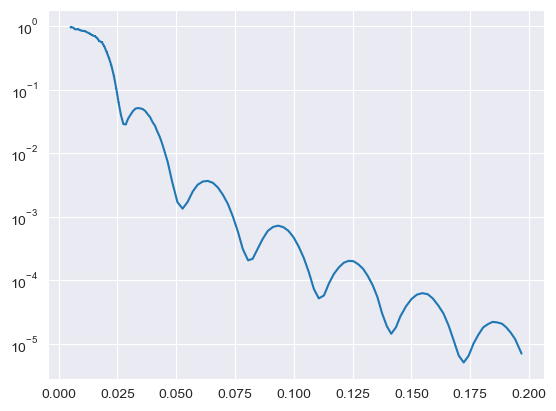

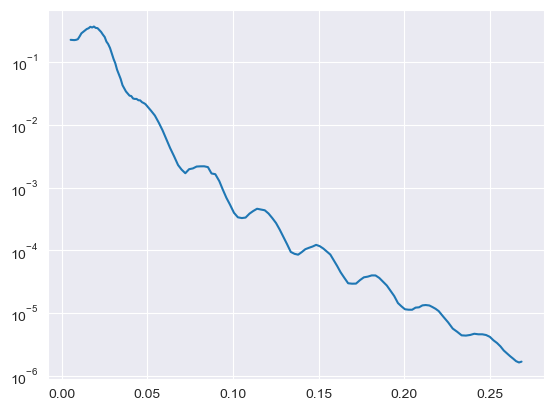

In [31]:
d_path = r"C:\Users\Harlan Heilman\Washington State University (email.wsu.edu)\Carbon Lab Research Group - Documents\Harlan Heilman\.refl\data"
def to_refnx_dataset(refl):
    data = (refl.Q, refl.Refl, refl.Err)
    return ReflectDataset(data)

e_list = [250, 283.7]

zrt_250_100 = pd.read_csv(d_path + r"\zrt_250.0_100.csv", index_col=0)
zrt_250_190 = pd.read_csv(d_path + r"\zrt_250.0_190.csv", index_col=0)
zrt_250_190 = zrt_250_190.where(zrt_250_190.Refl > 1e-6).dropna()

zrt_283p7_100 = pd.read_csv(d_path + r"\zrt_283.7_100.csv", index_col=0)
zrt_283p7_190 = pd.read_csv(d_path + r"\zrt_283.7_190.csv", index_col=0)
zrt_283p7_190 = zrt_283p7_190.where(zrt_283p7_190.Refl > .129e-6).dropna()

zrt_250_100 = zrt_250_100.iloc[4:]
zrt_283p7_100 = zrt_283p7_100.iloc[4:]

data_en1 = to_refnx_dataset(zrt_250_100)
data_en2 = to_refnx_dataset(zrt_283p7_100)

data_en1.plot()
plt.yscale('log')
data_en2.plot()
plt.yscale('log')

Now that we have removed the brewster angle, the next step is to generate a shared PXR_Slab objects that are identical between data-sets. Properties can then be determined though an input energy. To do this A series of inter-slab constraints are used to ensure identical structureal parameters (thickness, roughness, etc). While I am working to determine the best fits for the bare Si data, I will be using the current best results for the SiO2 and Adventitious carbon layers. That being a thickness of 10 $\AA$ of SiO2 and 5 $\AA$ of Carbon, with roughness of 2 $\AA$ and 2 $\AA$ respectively. 

In [32]:
si = PXR_MaterialSLD("Si", density=2.33, name = "Si")
sio2 = PXR_MaterialSLD("SiO2", density=2.28, name = "SiO2")

a_carbon_n = 0.0043 + 0.0053j
a_carbon = PXR_SLD(a_carbon_n, symmetry= "iso",name = "a-C")

x_zrt = 0.004 + 0.005j
x_zrt = PXR_SLD(x_zrt, symmetry= "iso", name = "ZnPc Room Temp")

vacuum = PXR_MaterialSLD("", density=1, name = "Vacuum")

si_slab = si(0, 0.5)
sio2_slab = sio2(11.57, 2.97)
carbon_slab = a_carbon(3, 3)
zrt_slab = x_zrt(200, 2)

When we call `PXR_ReflectModel` it will update the structure based on the given input energies. This will allow us to use the same structure for all energies.

## Building the Energy Dep Structure

The znpc layers will be constructed using uniaxial optical parameters, these are energy dependent. For the 250 eV data set, the only thing we hope to really find is the material parameters, while the resonant energy will help us to find the optical constants. This means we will use the scalar index of refraction for the 250 eV data set, and the uniaxial optical constants for the 283.7  eV data set.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

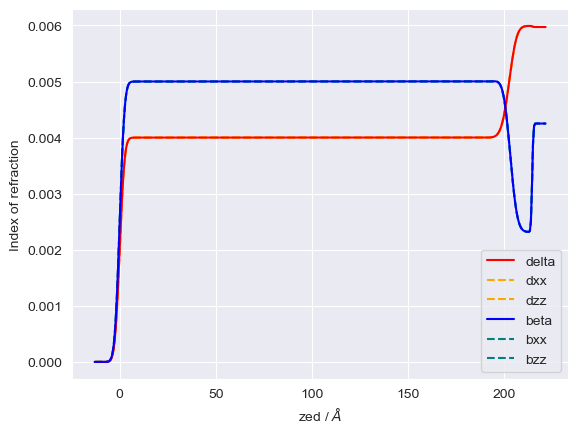

In [33]:
#  Build structures for each energy independently

structure_en1 = vacuum | zrt_slab | carbon_slab | sio2_slab | si_slab

structure_en1.plot()

## Making a multi-energy objective function
The new goal is to use the individual structures to create a full objective function that can be fit.

Now we can spescify the photon energies for each model, updating the carbon, SiO2 and Si layers to use the same structure, and uses the defined slabs for the znpc layers.

(<Figure size 640x480 with 1 Axes>, <Axes: >)

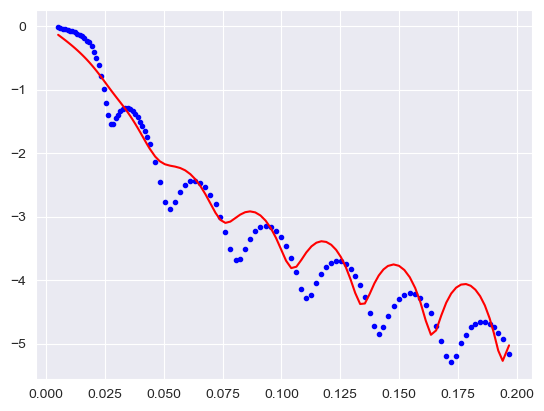

In [36]:
model = PXR_ReflectModel(structure_en1, energy=e_list[0], pol = "s")

obj_en1 = Objective(model, data_en1, transform=Transform("logY"))
obj_en1.plot()

From these initial model comparisons, it looks like the predicted roughness is way to high to agree with the model. We will try out some basic fitting to see how that does to imporve these initial structural guesses. 

## Enforcing inter-Energy constraints

Now that we 

In [37]:
# Fixed parameters from bare si fitting
si_slab.thick.setp(vary=False)
sio2_slab.thick.setp(vary=False)

zrt_slab.thick.setp(vary=True, bounds=(100, 300))
zrt_slab.rough.setp(vary=True, bounds=(0, 10))
zrt_slab.sld.delta.setp(vary=False)
zrt_slab.sld.beta.setp(vary=False)

2382825220218187.0: : 26it [00:02, 10.15it/s]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

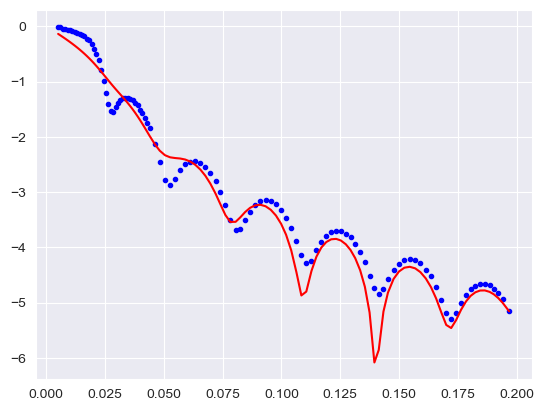

In [38]:
fitter = CurveFitter(obj_en1)
fitter.fit("differential_evolution")
obj_en1.plot()